In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [2]:
from utils.dataloader import *

rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath=rootpath)

# 모델로드

In [3]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

state_dict = torch.load("./weights/pspnet50_5.pth", map_location={"cuda:1":"cpu"})
net.load_state_dict(state_dict)
print("네트워크 설정 완료 : 학습된 가중치를 로드했습니다")


네트워크 설정 완료 : 학습된 가중치를 로드했습니다


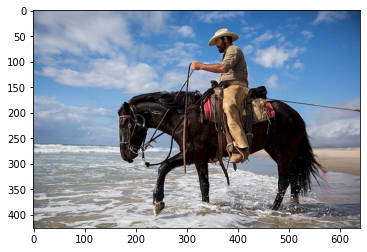

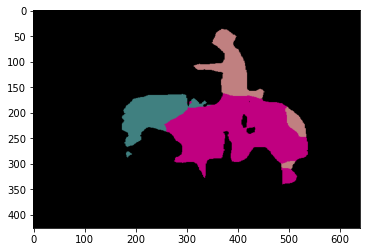

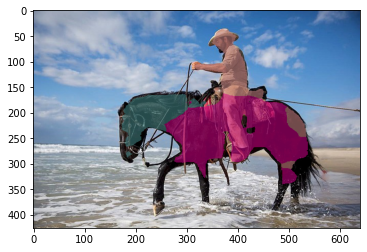

In [5]:
# 1. 원본 화상 표시
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 전처리 클래스 작성
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 전처리
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)
p_palette = anno_class_img.getpalette()
phase="val"
img, anno_class_img = transform(phase, img, anno_class_img)

# 4. PSPNet으로 추론
net.eval()
x = img.unsqueeze(0)
outputs = net(x)
y = outputs[0]

y = y[0].detach().numpy()
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 6. 화상을 투과시켜 겹친다
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # 색상 팔레트 형식을 RGBA로 변환

for x in range(img_width):
    for y in range(img_height):
        # 추론 결과 화상의 픽셀 데이터를 취득
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)의 배경이라면 그대로 투과시킨다
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # 그 외 색상은 준비된 화상에 픽셀을 기록한다
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 투과율을 150으로 지정한다

img = Image.open(image_file_path)   # [높이][폭][색RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()
